In [1]:
import numpy as np
import pandas as pd 
import scipy.io 
import matplotlib.pyplot as plt 
import stackprinter 
import matplotlib.mlab as mlab
import random
from mxnet import nd

In [2]:
stackprinter.set_excepthook(style='darkbg2')

# 1.  Sequential Bayesian Learning

In [3]:
data = scipy.io.loadmat('1_data.mat')

In [4]:
train = data['x']
target = data['t']

## 1.1 please generate five curve samples from the parameter posterior distribution.

### Sigmoidal basis function : 
$$\phi_j(x) = \sigma(\frac{x-\mu_j}{s}) $$
$$ \sigma(a) = \frac{1}{1+exp(-a)}  $$
$$and\ the\ setting\ is : M = 3, s= 0.1 , \mu_j = \frac{2j}{M}$$

In [5]:
def phi(x , M , s) : 
    phi = []
    for i in range(M) :
        mu =  (i*2)/M 
        k = 1/(1+np.exp(-(x-mu)/s))
        phi.append(k)
    phi = np.asarray(phi).flatten().reshape((len(x),3),order = 'F')
    return phi 
    

$$p(w|t) = N(w|m_N,\ S_N)\ \rm{,where\ }$$  
$$S_N^{-1} = S_0^{-1} + \beta \Phi^T \Phi$$  
$$m_N = S_N (S_0^{-1}m_0 + \beta \Phi^T t)$$  
$$p(w)= N(w|m_0 = \bf0 ,\ S_0 = 10^{-6} \bf I) $$  
$$\beta = 1 $$

In [6]:
def Par(phi , s0 , m0, t) : 
    a = list()
    sn =  np.linalg.inv( np.linalg.inv(s0)+1*phi.T.dot(phi))
    mn = sn.dot(np.linalg.inv(s0).dot(m0)+b*phi.T.dot(t))
    a.append(sn)
    a.append(mn)
    return a 

In [7]:
def bi_normal(x, mean, covariance):
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**2 * np.linalg.det(covariance))) * 
            np.exp(-(x_m.T@np.linalg.inv(covariance)@(x_m)) / 2))



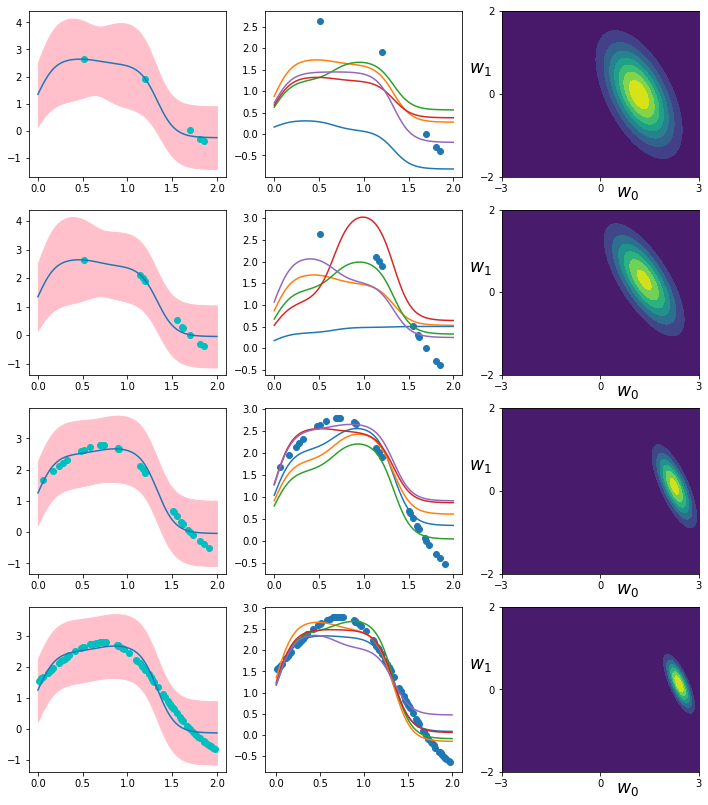

In [24]:
fig, axes = plt.subplots(4, 3, figsize=(12, 14))
size = [5, 10, 30, 80]
s0 = (10**(0))*np.eye(3)
m0 = np.zeros((3,1))
b = 1 
end = 0
for i in range(len(size)) : 
    start , end = end, size[i]
    
    train_x = train[start : end]
    target_t = target[start : end]
    phi_t = phi(train_x, 3, 0.1)
    par = Par(phi_t, s0, m0, target_t)
    m0 = par[1]
    s0 = par[0]
    for j in range(5) : 
        w = np.random.multivariate_normal(par[1].flatten(), par[0] , None , 'raise')
        x = np.linspace(0, 2, 100)
        fun = w[0]*(1/(1+np.exp(-(x-0)/0.1)))+w[1]*(1/(1+np.exp(-(x-2/3)/0.1)))+w[2]*(1/(1+np.exp(-(x-4/3)/0.1)))
        axes[i,1].plot(x,fun)
    axes[i,1].scatter(train[ : end], target[ : end]) 
    train_x = train[ : end]
    target_t = target[ : end]
    phi_t = phi(train_x, 3, 0.1)
    s = np.linalg.inv(1*phi_t.T.dot(phi_t) + 10**(-6) * np.eye(3))
    xx = np.linspace(0, 2, 500)
    y_0 = phi_t.T.dot(target_t)
    m_x = 1 * phi(xx, 3, 0.1).dot(s).dot(y_0).reshape(-1)
    s_xx = np.sqrt(1  + phi(xx, 3, 0.1).dot(s).dot(phi(xx, 3, 0.1).T).diagonal()).reshape(-1)
    axes[i, 0].plot(train_x, target_t, 'co')
    axes[i, 0].plot(xx, m_x)
    axes[i,0].fill_between(xx, m_x-s_xx, m_x+s_xx, color="pink")
    nb_of_x = 100 # grid size
    x1s = np.linspace(-3, 3, num=nb_of_x)
    x2s = np.linspace(-3, 3, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    m1 = m0[:2]
    s1 = s0[:2,:2]
    for k in range(nb_of_x):
        for l in range(nb_of_x):
            pdf[k,l] = bi_normal(
                np.matrix([[x1[k,l]], [x2[k,l]]]), 
                m1, s1)
    axes[i, 2].contourf(x1, x2, pdf)
    axes[i, 2].set_xticks([-3, 0, 3])
    axes[i, 2].set_yticks([-2, 0, 2])
    axes[i, 2].set_ylim(-2, 2)
    axes[i, 2].text(0.5, -2.5, '$w_0$', fontsize='xx-large')
    axes[i, 2].text(-4, 0.5, '$w_1$', fontsize='xx-large')
    
    
    

# 2 Logistic Regression

## 2.1 Set the initial w to be zero, and show the learning curve of E(w) and the accuracy of classification versus the number of epochs until convergence of training data. Gradient descent algorithm is applied.

In [3]:
import cv2 

In [4]:
cv2.imread('/Users/tommy84729/python/Faces/s1/1.pgm',0)

array([[115, 113, 113, ..., 111, 110, 110],
       [114, 117, 114, ..., 108, 112, 109],
       [116, 116, 117, ..., 106, 113, 112],
       ...,
       [ 99,  96, 101, ...,  52,  58,  49],
       [ 93, 101,  94, ...,  52,  51,  57],
       [ 99,  93, 101, ...,  56,  52,  55]], dtype=uint8)

In [264]:
train = list()
test = list()
true = list()
a = list(range(1,11))
for i in range(5) : 
    random.shuffle(a)
    a_f = a[ : 5]
    a_b = a[5 : ]
    k = [i+1]*5
    true += k
    for j in range(len(a_f)) : 
        b = cv2.imread('/Users/tommy84729/python/Faces/s{}/{}.pgm'.format(i+1 , j+1),0)
        train.append(b)
    for k in range(len(a_b)) : 
        b = cv2.imread('/Users/tommy84729/python/Faces/s{}/{}.pgm'.format(i+1 , j+1),0)
        test.append(b)
       

In [265]:
true = np.array(pd.get_dummies(true))

In [266]:
true

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [52]:
train_m = np.asmatrix(train[0].flatten())
for i in range(len(train)-1) : 
    train_m = np.vstack((train_m, np.asmatrix(train[i+1].flatten())))

test_m = np.asmatrix(test[0].flatten())
for i in range(len(test) - 1) : 
    test_m = np.vstack((test_m , np.asmatrix(train[i+1].flatten())))

train_m = train_m / 255 
test_m = test_m / 255 

## 建立Logistic REG 

In [89]:
w = np.zeros((5,10304))
b = 0

def softmax(x,W):
    vec=np.dot(x,W.T) 
    vec1=np.exp(vec)
    res=vec1.T/np.sum(vec1,axis=1)
    return res.T

def cross_entropy(features, target, w) : 
    scores = np.dot(features, w.T)
    cr = - np.sum(target.T*np.log(scores) + (1-target.T)*np.log(1-scores))
    return cr

def logit(features, target, learning_rate , iteration_times) : 
    w = np.zeros((5,10304))
    b = 0
    make_plot=[]
    for i in range(iteration_times) : 
        predict = np.array([])
        for j in range(len(features)) : 
            z1 = softmax(features[j], w)
            predict = np.append(predict,z1)
        predict = predict.reshape(25,-1)
        error = predict - true 
        gradient = np.dot(features.T, error)
        w -= learning_rate*gradient.T
        make_plot.append(- np.multiply(np.log(predict), target).sum())
        if i % 1000 == 0 : 
            print(error)
    return w, make_plot
    
    

In [70]:
ans = logit(train_m, true, 0.001, 50)

[[-0.8  0.2  0.2  0.2  0.2]
 [-0.8  0.2  0.2  0.2  0.2]
 [-0.8  0.2  0.2  0.2  0.2]
 [-0.8  0.2  0.2  0.2  0.2]
 [-0.8  0.2  0.2  0.2  0.2]
 [ 0.2 -0.8  0.2  0.2  0.2]
 [ 0.2 -0.8  0.2  0.2  0.2]
 [ 0.2 -0.8  0.2  0.2  0.2]
 [ 0.2 -0.8  0.2  0.2  0.2]
 [ 0.2 -0.8  0.2  0.2  0.2]
 [ 0.2  0.2 -0.8  0.2  0.2]
 [ 0.2  0.2 -0.8  0.2  0.2]
 [ 0.2  0.2 -0.8  0.2  0.2]
 [ 0.2  0.2 -0.8  0.2  0.2]
 [ 0.2  0.2 -0.8  0.2  0.2]
 [ 0.2  0.2  0.2 -0.8  0.2]
 [ 0.2  0.2  0.2 -0.8  0.2]
 [ 0.2  0.2  0.2 -0.8  0.2]
 [ 0.2  0.2  0.2 -0.8  0.2]
 [ 0.2  0.2  0.2 -0.8  0.2]
 [ 0.2  0.2  0.2  0.2 -0.8]
 [ 0.2  0.2  0.2  0.2 -0.8]
 [ 0.2  0.2  0.2  0.2 -0.8]
 [ 0.2  0.2  0.2  0.2 -0.8]
 [ 0.2  0.2  0.2  0.2 -0.8]]


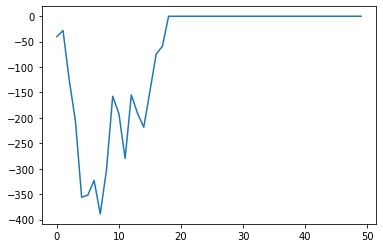

In [71]:
plt.plot(ans[1])

## 2.2 Show the classification result of test data.


## 將預測結果的矩陣計算出來

In [72]:
predict = np.array([])
for j in range(len(test_m)) : 
            z1 = softmax(test_m[j], ans[0])
            predict = np.append(predict , z1)
predict = predict.reshape(25,-1)


In [73]:
classification = pd.DataFrame(predict)
for i in range(len(classification)):
    print (classification.iloc[i , : ].idxmax()+1)

1
1
1
1
1
2
2
2
2
2
3
3
3
3
3
4
4
4
4
4
5
5
5
5
5


## 2.3 Use the principal component analysis (PCA) to reduce the dimension of data and plot five eigenvectors corresponding to top five eigenvalues.

In [13]:
mean = np.array([])
for i in range(train_m.shape[1]) : 
    mean = np.append(mean , np.mean(train_m[ : ,i]))
    

In [14]:
cov_mat = np.cov(train_m.T)

In [15]:
eig_val, eig_vec = np.linalg.eig(cov_mat)

In [17]:
eig_pairs = [(np.abs(eig_val[i]), eig_vec[:,i]) for i in range(len(eig_val))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)

In [227]:
def eigenvector(eig_pairs, d) : 
    w_pca = np.array([])
    for i in range(d) : 
        print(eig_pairs[i][0])
        w_pca = np.append(w_pca,eig_pairs[i][1])
    w_pca = np.array(w_pca.reshape(d, -1).T, dtype = 'float32')
    return w_pca

In [191]:
def logit_pca(train, w_pca, target, d, times) : 
    w = np.zeros((d,5))
    make_plot = []
    train_pca = train @ w_pca
    for i in range(times) : 
        y_hat = np.array([])
        for j in range(len(train_pca)) : 
            z1 = softmax(train_pca[j], w.T)
            y_hat = np.append(y_hat, z1)
        y_hat = y_hat.reshape(25,-1)
        R = np.diag(np.array([y_hat[i].dot(1-y_hat[i]) for i in range(len(y_hat))]))
        w = w - np.linalg.inv(train_pca.T @ R @ train_pca) @ train_pca.T @ (y_hat - target)
        make_plot.append(- np.multiply(np.log(y_hat), target).sum())
    return w ,make_plot

In [235]:
def predict_pca(test, w_pca) : 
    test_pca = test @ w_pca
    predict_pca = np.array([])
    for j in range(len(test_pca)) : 
                z1 = softmax(test_pca[j], w[0].T)
                predict_pca = np.append(predict_pca , z1)
    predict_pca = predict_pca.reshape(25,-1)
    classification = pd.DataFrame(predict_pca)
    for i in range(len(classification)) : 
        print (classification.iloc[i , : ].idxmax()+1)
    return predict_pca 

## d = 2 

## 取出前2的eigenvector 

In [237]:
w_pca_2 = eigenvector(eig_pairs, 2)

104.76741086173111
44.254179730430174


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [238]:
train_pca = train_m @ w_pca_2 
train_pca

matrix([[-19.4379867 ,  -2.38659449],
        [-17.86871937,  -0.84956823],
        [-17.44341958,  -2.74687667],
        [-20.23459593,  -0.54834164],
        [-19.88105961,   1.05645489],
        [-27.5677472 ,   9.90625608],
        [-27.07083019,  10.5505947 ],
        [-27.58686132,   9.08062602],
        [-30.15753915,  11.30249284],
        [-30.35516914,   9.58999754],
        [-20.46396495,  -9.05191997],
        [-18.67494893,  -9.25337781],
        [-22.31662073,  -9.1163344 ],
        [-19.96378789,  -8.86723901],
        [-20.91586872,  -9.50274217],
        [ -0.3023366 ,   5.30802836],
        [ -0.73946585,   5.57334385],
        [ -0.70019368,   5.62401184],
        [ -0.79611368,   4.31507854],
        [  0.23746619,   5.38053909],
        [ -6.14453971,   2.25578104],
        [ -8.89459506,  -0.9325976 ],
        [ -6.779929  ,   1.66676573],
        [ -7.90291918,   0.9774721 ],
        [ -7.61372807,  -0.60901615]])

In [239]:
w = logit_pca(train_m, w_pca_2, true, 2,250)

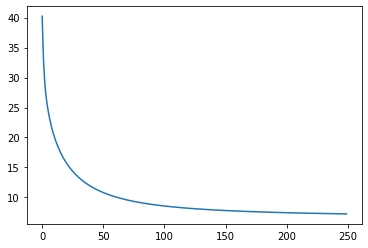

In [240]:
plt.plot(w[1])

In [241]:
predict_pca(test_m, w_pca_2)

1
1
1
1
1
2
2
2
2
2
3
3
3
3
3
4
4
4
4
4
2
1
5
5
1


array([[6.30008744e-01, 4.34043219e-03, 1.65803128e-05, 7.78228148e-08,
        3.65634165e-01],
       [8.11999822e-01, 4.59622218e-04, 9.87317627e-04, 5.13471469e-09,
        1.86553233e-01],
       [9.00266341e-01, 2.48020931e-05, 2.44807071e-02, 6.75187276e-11,
        7.52281501e-02],
       [8.07970362e-01, 3.39004964e-04, 2.13859182e-04, 1.20337174e-09,
        1.91476772e-01],
       [6.30008744e-01, 4.34043219e-03, 1.65803128e-05, 7.78228148e-08,
        3.65634165e-01],
       [7.29186276e-04, 9.64519848e-01, 7.53084796e-16, 4.17775147e-04,
        3.43331909e-02],
       [2.14425112e-04, 9.84018645e-01, 1.02790203e-16, 1.00921690e-03,
        1.47577134e-02],
       [2.76017876e-03, 9.14317558e-01, 1.00558661e-14, 1.89676634e-04,
        8.27325866e-02],
       [1.74143276e-04, 9.84335441e-01, 6.57753195e-18, 3.09971551e-04,
        1.51804445e-02],
       [2.95777008e-03, 8.96835404e-01, 1.42197320e-15, 5.58253893e-05,
        1.00151000e-01],
       [8.73063233e-03, 2.3219

### 可以看到如果只使用兩個維度的pca會在預測上有錯誤，集中在分類5的地方，總共有3個資料分類錯誤，且cross-entropy的收斂速度較慢

## d = 5 

### 取出前5的eigenvector

In [245]:
w_pca_5 = eigenvector(eig_pairs, 5)

104.76741086173111
44.254179730430174
27.086424290708358
15.042159265680228
13.001952847176662


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [246]:
train_pca = train_m @ w_pca_5
train_pca

matrix([[-19.4379867 ,  -2.38659449,   3.22501753,  -0.77348686,
           2.01910625],
        [-17.86871937,  -0.84956823,   7.65287071,   0.26449099,
           4.42046607],
        [-17.44341958,  -2.74687667,   2.82237669,  -0.34541861,
           1.85617399],
        [-20.23459593,  -0.54834164,   6.76400149,   1.79280284,
           4.15810433],
        [-19.88105961,   1.05645489,   8.49059376,   3.2983299 ,
           5.72226985],
        [-27.5677472 ,   9.90625608,  -5.18805126,   2.90963532,
           4.72754276],
        [-27.07083019,  10.5505947 ,  -5.97245455,   3.53880088,
           3.78677641],
        [-27.58686132,   9.08062602,  -5.29141348,   3.00048533,
           4.15569936],
        [-30.15753915,  11.30249284,  -6.04911617,   6.55495518,
           4.76433403],
        [-30.35516914,   9.58999754,  -4.15928281,   5.81410036,
           3.21200697],
        [-20.46396495,  -9.05191997, -10.50952329,   3.59928262,
           2.84733254],
        [-18.67494893

In [247]:
w = logit_pca(train_m, w_pca, true, 5, 50)

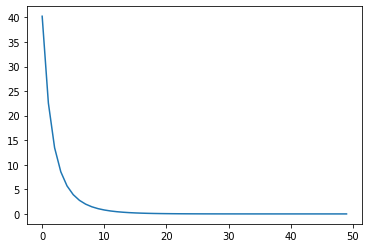

In [248]:
plt.plot(w[1])

In [249]:
predict_pca(test_m, w_pca_5)

1
1
1
1
1
2
2
2
2
2
3
3
3
3
3
4
4
4
4
4
5
5
5
5
5


array([[9.99999589e-01, 4.11469364e-07, 2.88269687e-15, 1.25140519e-16,
        2.33837924e-13],
       [9.99999972e-01, 2.78890758e-08, 1.01947077e-13, 7.33606877e-16,
        3.96859445e-15],
       [9.99994440e-01, 3.32029378e-06, 2.23808465e-06, 5.68216533e-11,
        1.84790447e-09],
       [9.99999700e-01, 2.99625591e-07, 1.32093206e-12, 1.23162110e-15,
        1.11201967e-12],
       [9.99999589e-01, 4.11469364e-07, 2.88269687e-15, 1.25140519e-16,
        2.33837924e-13],
       [6.72632252e-07, 9.99998038e-01, 7.31182325e-09, 1.28128231e-06,
        1.13961452e-09],
       [3.30267307e-08, 9.99999444e-01, 4.72895898e-09, 5.06150340e-07,
        1.22868574e-08],
       [1.27008634e-06, 9.99997478e-01, 5.48840173e-08, 1.18609825e-06,
        1.06988825e-08],
       [3.53539501e-09, 9.99999426e-01, 5.21418765e-10, 2.34984225e-08,
        5.45977995e-07],
       [3.73333422e-07, 9.99997806e-01, 1.00355531e-09, 4.77878384e-10,
        1.81939904e-06],
       [1.00918952e-15, 1.6601

### 可以看到在d = 5的情況下，收斂速度明顯比d = 2的時候快很多，且分類更為精準，可以看到在test的部分完全預測正確

## d = 10

In [251]:
w_pca_10 = eigenvector(eig_pairs, 10)

104.76741086173111
44.254179730430174
27.086424290708358
15.042159265680228
13.001952847176662
10.00637439218358
8.56148519795772
7.0767887290155285
5.695811376176451
5.264467946180629


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [252]:
train_pca = train_m @ w_pca_10
train_pca

matrix([[-19.4379867 ,  -2.38659449,   3.22501753,  -0.77348686,
           2.01910625,   9.39921526,  17.11476927,  10.07072119,
           3.10737594,   3.65772121],
        [-17.86871937,  -0.84956823,   7.65287071,   0.26449099,
           4.42046607,  12.9490976 ,  17.80367967,   0.95261363,
           3.150504  ,   2.44031428],
        [-17.44341958,  -2.74687667,   2.82237669,  -0.34541861,
           1.85617399,   8.20390212,  18.81392476,  11.0343278 ,
           4.46998679,   4.51261053],
        [-20.23459593,  -0.54834164,   6.76400149,   1.79280284,
           4.15810433,  15.27909634,  20.96886322,   4.08981734,
           1.62902701,   1.29342213],
        [-19.88105961,   1.05645489,   8.49059376,   3.2983299 ,
           5.72226985,  16.58092259,  21.7022751 ,   1.13063165,
           0.521242  ,   2.45168671],
        [-27.5677472 ,   9.90625608,  -5.18805126,   2.90963532,
           4.72754276,  11.33684658,  17.0419315 ,   2.31171789,
           6.04340163,   4.038

In [253]:
w = logit_pca(train_m, w_pca_10, true, 10, 30)

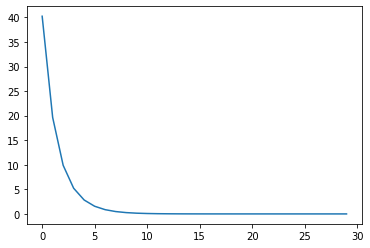

In [254]:
plt.plot(w[1])

In [255]:
predict_pca(test_m, w_pca_10)

1
1
1
1
1
2
2
2
2
2
3
3
3
3
3
4
4
4
4
4
5
5
5
5
5


array([[9.99999982e-01, 3.92104200e-09, 1.03039383e-09, 7.51831004e-09,
        5.54228226e-09],
       [9.99999993e-01, 2.45633508e-09, 2.29144190e-09, 1.68988409e-09,
        7.97216360e-10],
       [9.99999945e-01, 6.44367770e-09, 5.18058063e-09, 1.76213040e-08,
        2.60943281e-08],
       [9.99999970e-01, 4.09226175e-09, 1.00383932e-08, 4.56670759e-09,
        1.15536196e-08],
       [9.99999982e-01, 3.92104200e-09, 1.03039383e-09, 7.51831004e-09,
        5.54228226e-09],
       [1.87291646e-11, 9.99999999e-01, 5.22470955e-10, 1.22076579e-10,
        4.94274775e-12],
       [2.46739440e-12, 1.00000000e+00, 3.01885088e-10, 8.83409013e-11,
        1.46369957e-11],
       [8.92235272e-11, 9.99999997e-01, 2.78324958e-09, 2.79639939e-10,
        5.32583177e-11],
       [4.03539672e-11, 9.99999987e-01, 2.53358803e-09, 1.00594417e-08,
        3.46039531e-10],
       [3.22412572e-08, 9.99999917e-01, 1.05814875e-08, 1.05355290e-08,
        2.96093568e-08],
       [3.11873279e-18, 1.2401

### 最後是d = 10 ， 可以看到收斂的速度又比前面兩者更快，且預測的準確度也是100%

# 3. Nonparametric Methods 

## 3.1 
### Use the class with the largest number of occurrences for those K closest training samples to test sample as the prediction of this test sample.

In [ ]:
poke = pd.read_csv('Pokemon.csv').iloc[ : , 1 :  ]
poke.iloc[ : , 2:] = poke.iloc[ : , 2 : ].apply(lambda x : (x-x.mean())/x.std())

In [262]:
train_poke = poke.iloc[ :120,: ]
test_poke = poke.iloc[120 : ,: ]

### 定義距離函數（拿掉了非數值的資料以及generation）

In [ ]:
def eucl_dist(row1 , row2) : 
    a = np.array(row1.iloc[: , : ])  
    b = np.array(row2.iloc[: , : ])
    distance = np.sum((a-b) ** 2)
    return math.sqrt(distance)

### 定義相鄰函數以及預測函數（包含了考慮平票的預測函數：predict_1）

In [ ]:
def takeSecond(elem):
    return elem[1]

def get_neighbors(train, test_flow, k) : 
    cal_a = list()
    for j in range(len(train)) : 
        a = eucl_dist(train.iloc[j:j+1,:], test_flow)
        cal_a.append((train_poke.loc[j, 'Type 1'] , a))
    cal_a.sort(key = takeSecond)
    return cal_a[ : k] 

def predict(train, test, k) : 
    pred = list()
    for i in range(len(test)) : 
        test_flow = test.iloc[i : i+1, : ]
        cal = get_neighbors(train, test_flow, k)
        output_values = [row[0] for row in cal]
        prediction = max(set(output_values), key=output_values.count)
        pred.append(prediction)
    return pred 
        
def predict_1(train, test, k) : 
    pred = list()
    for i in range(len(test)) : 
        test_flow = test.iloc[i : i+1, : ]
        cal = get_neighbors(train, test_flow, k)
        output_values = [row[0] for row in cal]
        prediction = max(set(output_values), key=output_values.count)
        category = set(poke.loc[ : , 'Type 1'])
        category.remove(prediction)
        check = list(category)
        a = output_values.count(check[0])
        b = output_values.count(check[1])
        k_new = k
        while a == output_values.count(prediction) or b == output_values.count(prediction) : 
            k_new -= 1
            cal = get_neighbors(train, test_flow, k_new)
            output_values = [row[0] for row in cal]
            prediction = max(set(output_values), key=output_values.count)
            category = set(poke.loc[ : , 'Type 1'])
            category.remove(prediction)
            check = list(category)
            a = output_values.count(check[0])
            b = output_values.count(check[1])
            print(k_new)
        else : 
            pred.append(prediction)
    return pred 

In [ ]:
correct = list()
for i in range(1,11) : 
    table = pd.DataFrame(predict(train_poke.iloc[:, 2:], test_poke.iloc[:, 2:], i), index = None)
    table = pd.concat([test_poke.iloc[:, 1:2].reset_index(drop = True),table], ignore_index= True, axis= 1)
    table['correct'] = np.where(table[0] == table[1], 1,0)
    a = table['correct'].sum() / 38
    correct.append(a)
plt.title('KNN Accuracy')
plt.xlabel('K')
plt.ylabel('accuracy')
plt.plot(range(1,11),correct)

### 考慮平票的預測：

In [ ]:
correct = list()
for i in range(1,11) : 
    table = pd.DataFrame(predict_1(train_poke.iloc[:, 2:], test_poke.iloc[:, 2:], i), index = None)
    table = pd.concat([test_poke.iloc[:, 1:2].reset_index(drop = True),table], ignore_index= True, axis= 1)
    table['correct'] = np.where(table[0] == table[1], 1,0)
    a = table['correct'].sum() / 38
    correct.append(a)
plt.title('KNN Accuracy')
plt.xlabel('K')
plt.ylabel('accuracy')
plt.plot(range(1,11),correct)

# 3.2 KNN with PCA 

In [ ]:
train_poke_pca = train_poke.iloc[ :, 2: ]
test_poke_pca = test_poke.iloc[ : , 2: ]
cov_poke = np.cov(train_poke_pca.T)

In [ ]:
eig_val_poke, eig_vec_poke = np.linalg.eig(cov_poke)
eig_pairs_poke = [(np.abs(eig_val_poke[i]), eig_vec_poke[:,i]) for i in range(len(eig_val_poke))]
eig_pairs_poke.sort(key=lambda x: x[0], reverse=True)

### 定義選取eigenvector個數的函數

In [ ]:
def eigenvector(eig_pairs, d) : 
    w_pca = np.array([])
    for i in range(d) : 
        print(eig_pairs[i][0])
        w_pca = np.append(w_pca,eig_pairs[i][1])
    w_pca = np.array(w_pca.reshape(d, -1).T, dtype = 'float32')
    return w_pca

### D = 7

In [ ]:
poke_pca = eigenvector(eig_pairs_poke,7)

### 將train和test透過我們找出的pca降維

In [ ]:
train_pca = train_poke_pca @ poke_pca
test_pca = test_poke_pca @ poke_pca

In [ ]:
correct_pca = list()
for i in range(1,11) : 
    table = pd.DataFrame(predict(train_pca, test_pca, i), index = None)
    table = pd.concat([test_poke.iloc[:, 1:2].reset_index(drop = True),table], ignore_index= True, axis= 1)
    table['correct'] = np.where(table[0] == table[1], 1,0)
    a = table['correct'].sum() / 38
    correct_pca.append(a)
plt.title('KNN Accuracy')
plt.xlabel('K')
plt.ylabel('accuracy')
plt.plot(range(1,11),correct_pca) 

### D = 6 

In [ ]:
poke_pca = eigenvector(eig_pairs_poke,6)

In [ ]:
train_pca = train_poke_pca @ poke_pca
test_pca = test_poke_pca @ poke_pca

In [ ]:
correct_pca = list()
for i in range(1,11) : 
    table = pd.DataFrame(predict(train_pca, test_pca, i), index = None)
    table = pd.concat([test_poke.iloc[:, 1:2].reset_index(drop = True),table], ignore_index= True, axis= 1)
    table['correct'] = np.where(table[0] == table[1], 1,0)
    a = table['correct'].sum() / 38
    correct_pca.append(a)
plt.title('KNN Accuracy')
plt.xlabel('K')
plt.ylabel('accuracy')
plt.plot(range(1,11),correct_pca)

### D = 5 

In [ ]:
poke_pca = eigenvector(eig_pairs_poke,5)

In [ ]:
train_pca = train_poke_pca @ poke_pca
test_pca = test_poke_pca @ poke_pca

In [ ]:
correct_pca = list()
for i in range(1,11) : 
    table = pd.DataFrame(predict(train_pca, test_pca, i), index = None)
    table = pd.concat([test_poke.iloc[:, 1:2].reset_index(drop = True),table], ignore_index= True, axis= 1)
    table['correct'] = np.where(table[0] == table[1], 1,0)
    a = table['correct'].sum() / 38
    correct_pca.append(a)
plt.title('KNN Accuracy')
plt.xlabel('K')
plt.ylabel('accuracy')
plt.plot(range(1,11),correct_pca)